In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import cv2
import os
%matplotlib inline 

In [2]:
base_directory='../input/chest-xray-pneumonia/'
train_pneumonia=os.listdir('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')
test_dir_normal=os.listdir('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/')

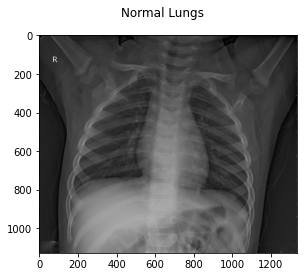

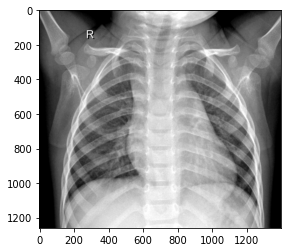

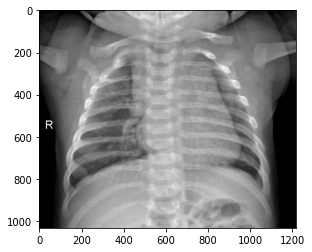

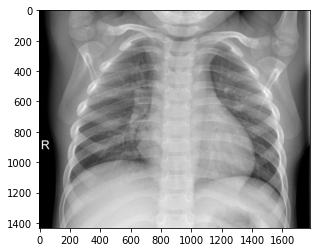

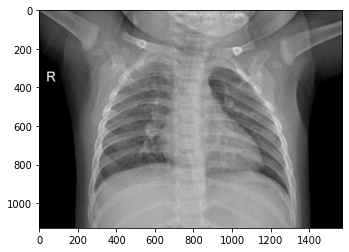

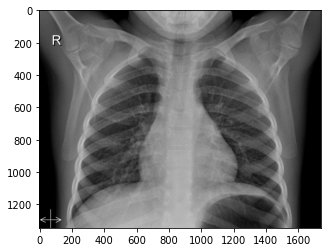

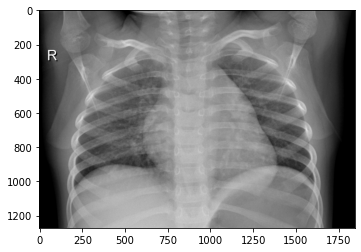

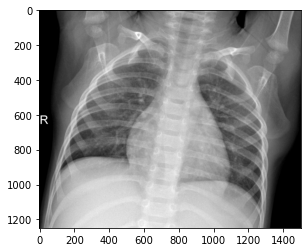

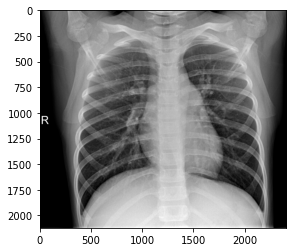

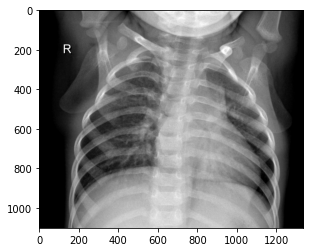

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img
plt.suptitle('Normal Lungs')
for i in range(0,10):
    img = train_normal[i]
    img = load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/' + img)
    plt.imshow(img)
    plt.show()

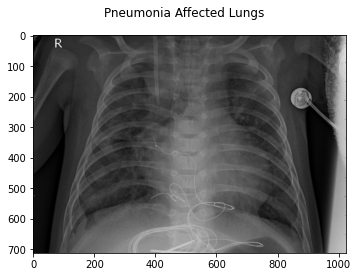

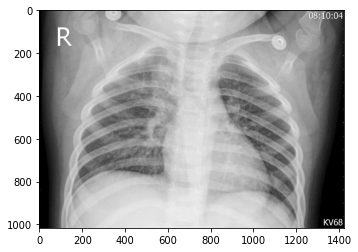

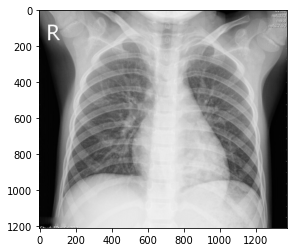

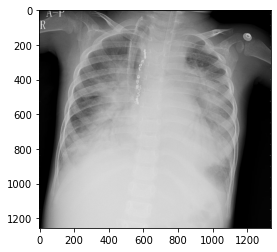

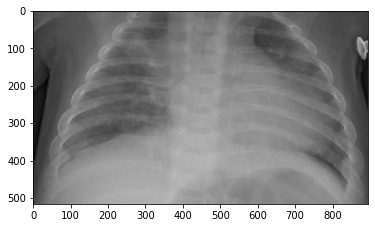

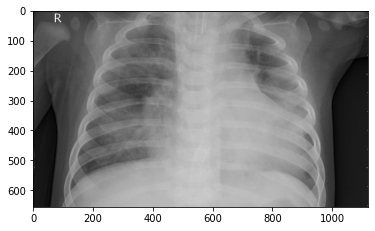

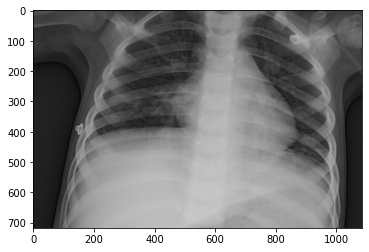

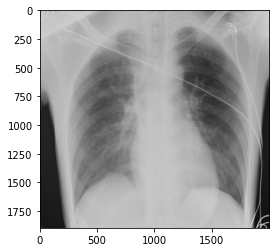

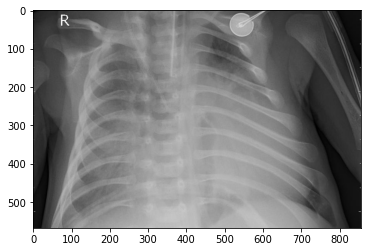

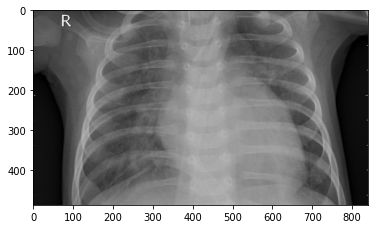

In [4]:
from keras.preprocessing.image import ImageDataGenerator, load_img
plt.suptitle('Pneumonia Affected Lungs')
for i in range(0,10):
    img = train_pneumonia[i]
    img = load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/' + img)
    plt.imshow(img)
    plt.show()

<AxesSubplot:>

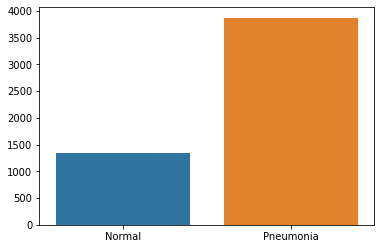

In [5]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(train_normal),len(train_pneumonia)])

In [ ]:
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_acc", mode="max", verbose = 2)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = model.fit_generator(epochs=10, callbacks=[early_stopping_monitor], shuffle=True, validation_data=test_batches, generator=train_batches,verbose=2)
prediction = model.predict_generator(generator=train_batches, verbose=2)

<AxesSubplot:>

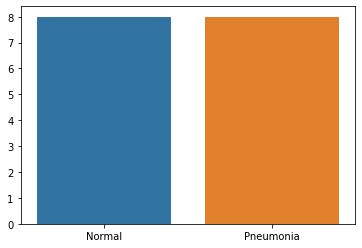

In [6]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(val_dir_normal),len(val_dir_pneumonia)])

<AxesSubplot:>

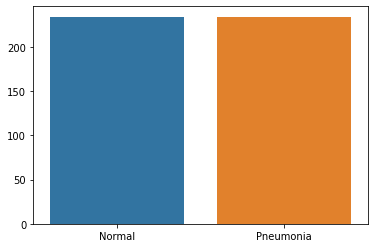

In [7]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(test_dir_normal),len(test_dir_pneumonia)])

In [10]:
y_train_temp=[]
for i in range(len(train_normal)):
    y_train_temp.append(0)
for i in range(len(train_pneumonia)):
    y_train_temp.append(1)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=7,
    width_shift_range=0.5,
    height_shift_range=0.45,
    shear_range=0.2,
    zoom_range=0.45,
    horizontal_flip=True
    
)
test_datagen=ImageDataGenerator(
    rescale=1/255.0
)

In [21]:
train_set=train_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train/',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 shuffle=True,
                                                 class_mode='binary')

Found 5216 images belonging to 2 classes.


In [22]:
val_set=test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/val/',
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='binary'
                                        )

Found 16 images belonging to 2 classes.


In [23]:
test_set=test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test/',
                                          target_size=(224,224),
                                          batch_size=1,
                                          class_mode='binary',
                                          shuffle=False
)

Found 624 images belonging to 2 classes.


In [28]:
import tensorflow as tf
inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(224,224,3),weights='imagenet')
layer=inception.get_layer('mixed7')
x=tf.keras.layers.Flatten()(layer.output)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs=inception.input,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy','mae'])


In [29]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_190 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [30]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [31]:
my_callback = MyThresholdCallback(threshold=0.94)
history = model.fit_generator(train_set,
                    epochs=30,
                    validation_data=test_set,
                    callbacks=[my_callback]
                    )

Epoch 1/30
163/163 [==============================] - 148s 842ms/step - loss: 0.3954 - accuracy: 0.8808 - mae: 0.1727 - val_loss: 6.2427 - val_accuracy: 0.6827 - val_mae: 0.3190
Epoch 2/30
163/163 [==============================] - 136s 835ms/step - loss: 0.1505 - accuracy: 0.9403 - mae: 0.0822 - val_loss: 2.7250 - val_accuracy: 0.8654 - val_mae: 0.1384
Epoch 3/30
163/163 [==============================] - 136s 831ms/step - loss: 0.1404 - accuracy: 0.9483 - mae: 0.0756 - val_loss: 3.9080 - val_accuracy: 0.8718 - val_mae: 0.1259
Epoch 4/30
163/163 [==============================] - 135s 825ms/step - loss: 0.0961 - accuracy: 0.9679 - mae: 0.0493 - val_loss: 36.3619 - val_accuracy: 0.6859 - val_mae: 0.3154
Epoch 5/30
163/163 [==============================] - 135s 828ms/step - loss: 0.0971 - accuracy: 0.9650 - mae: 0.0499 - val_loss: 0.9313 - val_accuracy: 0.8542 - val_mae: 0.1465
Epoch 6/30
163/163 [==============================] - 137s 840ms/step - loss: 0.1024 - accuracy: 0.9658 - mae

In [32]:
predict=model.evaluate(test_set)


624/624 [==============================] - 11s 18ms/step - loss: 0.3012 - accuracy: 0.9599 - mae: 0.0474


In [33]:
predicted=model.predict_generator(test_set,steps=624)
result=np.array(predicted>0.5,dtype='int32')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [34]:
x_test=test_set.classes
tester1=x_test.reshape((624,1))

In [35]:
from sklearn.metrics import confusion_matrix
metrics=confusion_matrix(test_set.classes,result)
print(metrics)

[[217  17]
 [  8 382]]


In [36]:
from sklearn.metrics import auc,roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(x_test,predicted)
auc = roc_auc_score(x_test, predicted)

In [37]:
print(auc)

0.9844181459566074


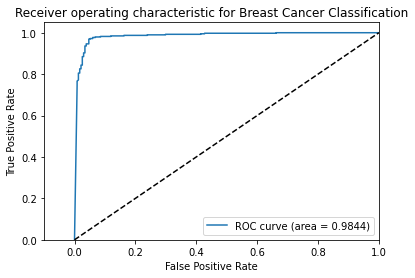

In [38]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr,label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Breast Cancer Classification')
plt.legend(loc="lower right")
plt.show()

In [39]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")